In [32]:
import sys
import jsonpickle
import os
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import json
import datetime
import pandas
import emoji

#defining attributes
#positive and negative emotion words
emotion_words = [0,0]
#positive and negative emoticons and emojis
emoticons = [0,0]
#punctuation marks !,?,...,.
punc_marks=[0,0,0,0]
#degree adverbs
degree=[0,0]
#no of comments,retweets and likes
social_attn=[0,0,0]



#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

POSITIVE = ["*O", "*-*", "*O*", "*o*", "* *",
                ":P", ":D", ":d", ":p",
                ";P", ";D", ";d", ";p",
                ":-)", ";-)", ":=)", ";=)",
                ":<)", ":>)", ";>)", ";=)",
                "=}", ":)", "(:;)",
                "(;", ":}", "{:", ";}",
                "{;:]",
                "[;", ":')", ";')", ":-3",
                "{;", ":]",
                ";-3", ":-x", ";-x", ":-X",
                ";-X", ":-}", ";-=}", ":-]",
                ";-]", ":-.)",
                "^_^", "^-^"]

NEGATIVE = [":(", ";(", ":'(",
                "=(", "={", "):", ");",
                ")':", ")';", ")=", "}=",
                ";-{{", ";-{", ":-{{", ":-{",
                ":-(", ";-(",
                ":,)", ":'{",
                "[:", ";]"
]

emopos = ["😀","😁","😂","🤣","😃","😄","😅","😆","😉","😊","😋","😎","😍","😘","🥰","😗","😙","😚","☺️","🙂","🤗","🤩","😴"
          "😌","😛","😜","😝","🤤","🤑","😬","😇","🤠","🤡","🥳","🤭","🧐","🤓","😈""👻","👽","🤖","😺","😸","😹","😻","😽"]



emoneg = ["🤔","🤨","😐","😑","😶","🙄","😏","😣","😥","😮","🤐","😯","😪","😫","😒","😓","😔","😕","🙃","😲","☹️","🙁","😖","😞","😟","😤","😢","😭","😦","😧","😨","😩","🤯",
          "😰","😱","🥵","🥶","😳","🤪","😵","😡","😠","🤬","😷","🤒","🤕","🤢","🤮","🤧","🥴","🥺","🤥","🤫","👿","👹","👺","💀","😼","🙀","😿","😾"]


  
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''      
        
    
        
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
        consumer_key = 'koB9DtzCdzBpYWWWuGZaAZfQ4'
        consumer_secret = 'sidV3z48EbrcBtnp7ga9843CVe0ddoVungGIeMMwSbvS3Fu1En'
        access_token = '922408940616351744-XOeNML7LFT92plNNzklsN6BTLt8QjD2'
        access_token_secret = 'RpddoO7TsSory7sFLbNYNGL9gZxlsdQ1LeCDtZ7uAoV05'
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
         
  
    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
                                               

    def get_punc(str,pun):
        count = 0
        if pun =='...':
            for j in range(0,len(str)-2):
                if(str[j]=="." and str[j+1]=="." and str[j+2]=="."):
                    count = count + 1
        else:          
            for i in range (0, len (str)):   
                #Checks whether given character is a punctuation mark  
                if str[i] in (pun):  
                    count = count + 1
                
        return count
    
    def extract_emojis(str):
        return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)
    
    def get_pemoji(str):
        count = 0
        co = TextBlob(str)
        for i in POSITIVE:
            if i in co:
                count = count +1
        for j in emoticons_happy:
            if i in co:
                count = count +1
        n = TwitterClient.extract_emojis(str)
        for k in emopos:
            if k in n:
                count = count +1
        return count
    def get_nemoji(str):
        count = 0
        co = TextBlob(str)
        for i in NEGATIVE:
            if i in co:
                count = count +1
        for j in emoticons_sad:
            if i in co:
                count = count +1
        n = TwitterClient.extract_emojis(str)
        for k in emoneg:
            if k in n:
                count = count +1
        return count
    
    def get_pwords(str):
        count = 0
        a = TextBlob(str)
        for word in a.words:
            b = TextBlob(word)            
            if(b.sentiment.polarity>0):
                count = count + 1
        return count
    def get_nwords(str):
        count = 0
        a = TextBlob(str)
        for word in a.words:
            b = TextBlob(word)            
            if(b.sentiment.polarity>0):
                count = count + 1
        return count
    def gettime(date):
        return date._str_()
        
 
 
    
  
    def get_tweets(self, query, count = 30,mid=None,sid=None): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 
  
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count,max_id=mid,since_id=sid) 
  
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 
                # saving text of tweet 
                parsed_tweet['text'] = tweet.text 
                # saving sentiment of tweet 
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
                # savint tweet time
                #parsed_tweet['time'] =TwitterClient.gettime(tweet.created_at)
                #saving tweet's user id
                parsed_tweet['userid'] = tweet.id_str
                #saving emojis
                #parsed_tweet['emoji']=tweet.entities['symbols']
                #saving retweet count
                parsed_tweet['retweets_count'] = tweet.retweet_count
                #saving favorite count
                parsed_tweet['favorite_count'] = tweet.favorite_count
                #saving reply count
                #parsed_tweet['reply_count'] = tweet.reply_count
                #counting number of punctuation marks
                parsed_tweet['punc1']=TwitterClient.get_punc(tweet.text,'!')
                parsed_tweet['punc2']=TwitterClient.get_punc(tweet.text,'?')
                parsed_tweet['punc3']=TwitterClient.get_punc(tweet.text,'...')
                parsed_tweet['punc4']=TwitterClient.get_punc(tweet.text,'.') - 3*TwitterClient.get_punc(tweet.text,'...')
                #counting positve emojis
                parsed_tweet['pemoji']= TwitterClient.get_pemoji(tweet.text)
                #counting negative emojis
                parsed_tweet['nemoji'] = TwitterClient.get_nemoji(tweet.text)
                #counting positive words
                parsed_tweet['pword'] = TwitterClient.get_pwords(tweet.text)
                #counting negative words
                parsed_tweet['nword'] = TwitterClient.get_nwords(tweet.text)
                parsed_tweet['id']=tweet.id
                #counting  positive degree adverbs
                #parsed_tweet['padv'] = TwitterClient.get_padv(tweet.text)
                #counting negative degree adverbs
                #parsed_tweet['nadv'] = TwitterClient.get_nadv(tweet.text)
                
                
                
                
                
                #def function to convert json-serialilze datetime
                def default(o):
                    if isinstance(o, datetime.datetime):
                        return o.__str__()
   
                
                
                
                
                with open('twe6.json','a') as t:
  
                # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet)
                            qwe=json.dump(parsed_tweet,t)                            
                            t.write('\n')
                    else: 
                        tweets.append(parsed_tweet) 
                        qwe=json.dump(parsed_tweet,t)                        
                        t.write('\n')
               
   
            # return parsed tweets 
            return tweets
  
        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 
  
def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    #tweets = api.get_tweets(query = 'I feel stressed',count=100) 
    
    

    searchQuery = 'i feel stress'  # this is what we're searching for
    maxTweets = 1000 # Some arbitrary large number
    tweetsPerQry = 100  # this is the max the API permits
    fName = 'tweet.txt' # We'll store the tweets in a text file.


    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -1

    tweetCount = 0
    print("Downloading max {0} tweets".format(maxTweets))
    with open(fName, 'w') as f:
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = api.get_tweets(searchQuery, count=tweetsPerQry)
                    else:
                        new_tweets = api.get_tweets(searchQuery, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = api.get_tweets(searchQuery, count=tweetsPerQry, max_id=str(max_id - 1))
                    else:
                        new_tweets = api.get_tweets(searchQuery, count=tweetsPerQry,max_id=str(max_id - 1),since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                for tweet in new_tweets:
                    json.dump(tweet,f)
                    #f.write(jsonpickle.encode(tweet._json, unpicklable=False) +'\n')
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-86].id
            except tweepy.TweepError as e:
                # Just exit if any error
                print("some error : " + str(e))
                break

  
  
if __name__ == "__main__": 
    # calling main function 
    main() 

Downloaded 87 tweets


AttributeError: 'dict' object has no attribute 'id'

In [145]:
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import json
import datetime
from datetime import datetime
import pandas
import emoji

#defining attributes
#positive and negative emotion words
emotion_words = [0,0]
#positive and negative emoticons and emojis
emoticons = [0,0]
#punctuation marks !,?,...,.
punc_marks=[0,0,0,0]
#degree adverbs
degree=[0,0]
#no of comments,retweets and likes
social_attn=[0,0,0]



#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

POSITIVE = ["*O", "*-*", "*O*", "*o*", "* *",
                ":P", ":D", ":d", ":p",
                ";P", ";D", ";d", ";p",
                ":-)", ";-)", ":=)", ";=)",
                ":<)", ":>)", ";>)", ";=)",
                "=}", ":)", "(:;)",
                "(;", ":}", "{:", ";}",
                "{;:]",
                "[;", ":')", ";')", ":-3",
                "{;", ":]",
                ";-3", ":-x", ";-x", ":-X",
                ";-X", ":-}", ";-=}", ":-]",
                ";-]", ":-.)",
                "^_^", "^-^"]

NEGATIVE = [":(", ";(", ":'(",
                "=(", "={", "):", ");",
                ")':", ")';", ")=", "}=",
                ";-{{", ";-{", ":-{{", ":-{",
                ":-(", ";-(",
                ":,)", ":'{",
                "[:", ";]"
]

emopos = ["😀","😁","😂","🤣","😃","😄","😅","😆","😉","😊","😋","😎","😍","😘","🥰","😗","😙","😚","☺️","🙂","🤗","🤩","😴"
          "😌","😛","😜","😝","🤤","🤑","😬","😇","🤠","🤡","🥳","🤭","🧐","🤓","😈""👻","👽","🤖","😺","😸","😹","😻","😽"]



emoneg = ["🤔","🤨","😐","😑","😶","🙄","😏","😣","😥","😮","🤐","😯","😪","😫","😒","😓","😔","😕","🙃","😲","☹️","🙁","😖","😞","😟","😤","😢","😭","😦","😧","😨","😩","🤯",
          "😰","😱","🥵","🥶","😳","🤪","😵","😡","😠","🤬","😷","🤒","🤕","🤢","🤮","🤧","🥴","🥺","🤥","🤫","👿","👹","👺","💀","😼","🙀","😿","😾"]


  
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''      
        
    
        
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
        consumer_key = 'koB9DtzCdzBpYWWWuGZaAZfQ4'
        consumer_secret = 'sidV3z48EbrcBtnp7ga9843CVe0ddoVungGIeMMwSbvS3Fu1En'
        access_token = '922408940616351744-XOeNML7LFT92plNNzklsN6BTLt8QjD2'
        access_token_secret = 'RpddoO7TsSory7sFLbNYNGL9gZxlsdQ1LeCDtZ7uAoV05'
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
         
  
    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
                                               

    def get_punc(str,pun):
        count = 0
        if pun =='...':
            for j in range(0,len(str)-2):
                if(str[j]=="." and str[j+1]=="." and str[j+2]=="."):
                    count = count + 1
        else:          
            for i in range (0, len (str)):   
                #Checks whether given character is a punctuation mark  
                if str[i] in (pun):  
                    count = count + 1
                
        return count
    
    def extract_emojis(str):
        return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)
    
    def get_pemoji(str):
        count = 0
        co = TextBlob(str)
        for i in POSITIVE:
            if i in co:
                count = count +1
        for j in emoticons_happy:
            if i in co:
                count = count +1
        n = TwitterClient.extract_emojis(str)
        for k in emopos:
            if k in n:
                count = count +1
        return count
    def get_nemoji(str):
        count = 0
        co = TextBlob(str)
        for i in NEGATIVE:
            if i in co:
                count = count +1
        for j in emoticons_sad:
            if i in co:
                count = count +1
        n = TwitterClient.extract_emojis(str)
        for k in emoneg:
            if k in n:
                count = count +1
        return count
    
    def get_pwords(str):
        count = 0
        a = TextBlob(str)
        for word in a.words:
            b = TextBlob(word)            
            if(b.sentiment.polarity>0):
                count = count + 1
        return count
    def get_nwords(str):
        count = 0
        a = TextBlob(str)
        for word in a.words:
            b = TextBlob(word)            
            if(b.sentiment.polarity>0):
                count = count + 1
        return count
    def get_padv(str):
        a = TextBlob(str)
        if(a.sentiment.polarity>0):
            for word in a.tags:
                if word[1]=='JJS'or word[1]=='RBS':
                    return 3
                elif word[1]=='JJR'or word[1]=='RBR':
                    return 2
                else: 
                    return 1
        else:
            return 0

       
            
    def get_nadv(str):
        a = TextBlob(str)
        if(a.sentiment.polarity<0):        
            for word in a.tags:
                if word[1]=='JJS'or word[1]=='RBS':
                    return -3
                elif word[1]=='JJR'or word[1]=='RBR':
                    return -2
                else: 
                    return -1
        else:
            return 0
    
        
    def get_tweets(self, query, count = 30): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        #empty list to store parsed tweets 
        tweets = []  
        # call twitter api to fetch tweets 
        #fetched_tweets = self.api.search(q = query, count = count)         
            
        # Continue with rest of code
        searchQuery = 'i feel relaxed'  # this is what we're searching for
        maxTweets = 1000 # Some arbitrary large number
        tweetsPerQry = 100  # this is the max the API permits
        fName = 'ex.json' # We'll store the tweets in a text file.


        # If results from a specific ID onwards are reqd, set since_id to that ID.
        # else default to no lower limit, go as far back as API allows
        sinceId = None
            # If results only below a specific ID are, set max_id to that ID.
            # else default to no upper limit, start from the most recent tweet matching the search query.
        max_id = -1

        tweetCount = 0
        print("Downloading max {0} tweets".format(maxTweets))
        with open(fName, 'a') as f:
            while tweetCount < maxTweets:
                try:
                    if (max_id <= 0):
                        if (not sinceId):
                            new_tweets = self.api.search(q=searchQuery, count=tweetsPerQry)
                        else:
                            new_tweets = self.api.search(q=searchQuery, count=tweetsPerQry,since_id=sinceId)
                    else:
                        if (not sinceId):
                            new_tweets = self.api.search(q=searchQuery, count=tweetsPerQry,max_id=str(max_id - 1))
                        else:
                            new_tweets = self.api.search(q=searchQuery, count=tweetsPerQry,max_id=str(max_id - 1),since_id=sinceId)
                    if not new_tweets:
                        print("No more tweets found")
                        break
                    for tweet in new_tweets:
                        
                        parsed_tweet = {} 
                        # saving text of tweet 
                        parsed_tweet['text'] = tweet.text 
                        # saving sentiment of tweet 
                        parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)
                        # savint tweet time
                        parsed_tweet['time'] =tweet.created_at.strftime("%d-%b-%Y (%H:%M:%S.%f)")
                        #saving tweet's user id
                        parsed_tweet['userid'] = tweet.id_str
                        #saving emojis
                        #parsed_tweet['emoji']=tweet.entities['symbols']
                        #saving retweet count
                        parsed_tweet['retweets_count'] = tweet.retweet_count
                        #saving favorite count
                        parsed_tweet['favorite_count'] = tweet.favorite_count
                        #saving reply count
                        #parsed_tweet['reply_count'] = tweet.reply_count
                        #counting number of punctuation marks
                        parsed_tweet['punc1']=TwitterClient.get_punc(tweet.text,'!')
                        parsed_tweet['punc2']=TwitterClient.get_punc(tweet.text,'?')
                        parsed_tweet['punc3']=TwitterClient.get_punc(tweet.text,'...')
                        parsed_tweet['punc4']=TwitterClient.get_punc(tweet.text,'.') - 3*TwitterClient.get_punc(tweet.text,'...')
                        #counting positve emojis
                        parsed_tweet['pemoji']= TwitterClient.get_pemoji(tweet.text)
                        #counting negative emojis
                        parsed_tweet['nemoji'] = TwitterClient.get_nemoji(tweet.text)
                        #counting positive words
                        parsed_tweet['pword'] = TwitterClient.get_pwords(tweet.text)
                        #counting negative words
                        parsed_tweet['nword'] = TwitterClient.get_nwords(tweet.text)
                        #counting  positive degree adverbs      
                        parsed_tweet['padv'] = TwitterClient.get_padv(tweet.text)
                        #counting negative degree adverbs
                        parsed_tweet['nadv'] = TwitterClient.get_nadv(tweet.text)
                        parsed_tweet['result'] =0
                        if tweet.retweet_count > 0: 
                            # if tweet has retweets, ensure that it is appended only once 
                            if parsed_tweet not in tweets:
                                
                                #print(parsed_tweet)
                                tweets.append(parsed_tweet)
                                f.write(jsonpickle.encode(parsed_tweet, unpicklable=False) )
                                f.write('\n')
                                
                        else: 
                            tweets.append(parsed_tweet) 
                            f.write(jsonpickle.encode(parsed_tweet, unpicklable=False) )
                            f.write('\n')
                            
                        
                        
                        
                        
                       
                            
                    tweetCount += len(new_tweets)
                    print("Downloaded {0} tweets".format(tweetCount))
                    max_id = new_tweets[-1].id
                except tweepy.TweepError as e:
                    # Just exit if any error
                    print("some error : " + str(e))
                    break

            print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))
  
            # parsing tweets one by one 
                # empty dictionary to store required params of a tweet 
               
   
            # return parsed tweets 
        return tweets 
 
 
    
  
    
  
def main():    
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = 'I feel stressed',count=100) 
    #print(tweets[1]['text'])  
if __name__ == "__main__": 
    # calling main function 
    main() 


Downloaded 72 tweets
Downloaded 144 tweets
Downloaded 219 tweets
Downloaded 296 tweets
Downloaded 360 tweets


KeyboardInterrupt: 

Accuracy: 0.6437054631828979
Precision: 0.694300518134715
Recall: 0.5955555555555555


c:\users\yuvaneeth\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(33.0, 0.5, 'Actual label')

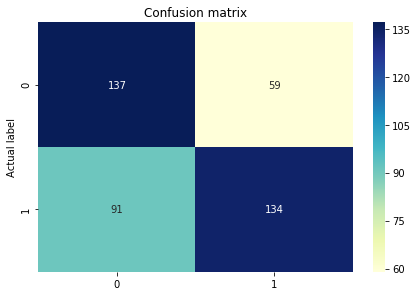

In [116]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

col_names = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count','result']
# load dataset
pima = pd.read_csv('final1.csv', header=None, names=col_names)
feature_cols = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count']
X = pima[feature_cols] # Features
y = pima.result # Target variable
# split X and y into training and testing sets

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)
# import the class

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')

In [123]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics

col_names = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count','result']
# load dataset
pima = pd.read_csv('final1.csv', header=None, names=col_names)
feature_cols = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count']
X = pima[feature_cols] # Features
y = pima.result # Target variable
# split X and y into training and testing sets
X = pima[feature_cols] # Features
y = pima.result # Target variable

print(pima.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=109) # 70% training and 30% test
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

(2101, 12)


c:\users\yuvaneeth\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.6957210776545166
Precision: 0.7629310344827587
Recall: 0.5636942675159236


Accuracy: 0.6751188589540412
Precision: 0.7104247104247104
Recall: 0.5859872611464968


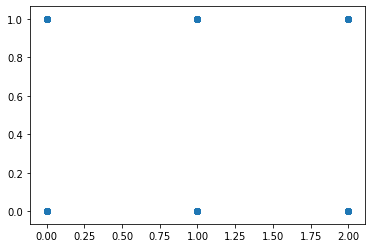

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

col_names = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count','result']
# load dataset
pima = pd.read_csv('final1.csv', header=None, names=col_names)
feature_cols = ['pword', 'nword', 'pemoji', 'nemoji', 'punc1', 'punc2', 'punc3', 'padv', 'nadv','favorite_count','retweets_count']
X = pima[feature_cols] # Features
y = pima.result # Target variable
# split X and y into training and testing sets
X = pima[feature_cols] # Features
y = pima.result # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))





b = y
c = X.favorite_count
d = X.nemoji
plt.scatter(d,b)

